In [55]:
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pylab as pl
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# print the JS visualization code to the notebook
shap.initjs()

/kaggle/input/water-potability/water_potability.csv


## Data Analysis

In [57]:
df = pd.read_csv("/kaggle/input/water-potability/water_potability.csv")

In [58]:
df.head(10)  # Classification problem: predicting potability

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


In [5]:
df.describe()
# ph has 491 (15.0%) missing values
# Sulfate has 781 (23.8%) missing values
# Trihalomethanes has 162 (4.9%) missing values

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [6]:
from pandas_profiling import ProfileReport

In [7]:
prof = ProfileReport(df)
prof.to_file(output_file="EDA.html")

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Engineering

In [8]:
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

## Sulfate Data Engineering

In [60]:
for col in df.loc[:, ~df.columns.isin(["Sulfate"])].columns:
    df[col] = df[col].fillna(
        df[col].mean()
    )  # mean imputation for all columns but Sulfate

In [65]:
from sklearn.preprocessing import MinMaxScaler

In [82]:
df_sulf = df[df.Sulfate.notnull()]

y = df_sulf["Sulfate"]
X = df_sulf.loc[:, ~df.columns.isin(["Sulfate", "Potability"])]

In [84]:
scaler = MinMaxScaler()
X = scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [85]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor()
regressor.fit(X=X_train, y=y_train)

KNeighborsRegressor()

In [101]:
prediction = regressor.predict(X=X_test)

In [102]:
df_Na = df[~df.Sulfate.notnull()]

In [94]:
df_Na2 = df_Na.loc[:, ~df.columns.isin(["Sulfate", "Potability"])]

In [95]:
df_Na2 = scaler.transform(df_Na2)

In [96]:
filled_NA = regressor.predict(X=df_Na2)

In [103]:
df_Na = df_Na.loc[:, ~df.columns.isin(["Sulfate"])]

In [105]:
df_Na["Sulfate"] = filled_NA

In [107]:
df_Na  # filled NA
df_nonNa = df[df.Sulfate.notnull()]  # notnull
final_df = pd.concat([df_Na, df_nonNa])

In [109]:
final_df.describe()

,ph,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,Sulfate
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,426.205111,14.284970,66.396293,3.966786,0.390110,334.949238
std,1.469956,32.879761,8768.570828,1.583085,80.824064,3.308162,15.769881,0.780382,0.487849,37.565385
min,0.000000,47.432000,320.942611,0.352000,181.483754,2.200000,0.738000,1.450000,0.000000,129.000000
25%,6.277673,176.850538,15666.690297,6.127421,365.734414,12.065801,56.647656,3.439711,0.000000,314.078838
50%,7.080795,196.967627,20927.833607,7.130299,421.884968,14.218338,66.396293,3.955028,0.000000,334.881478
75%,7.870050,216.667456,27332.762127,8.114887,481.792304,16.557652,76.666609,4.500320,1.000000,356.308113
max,14.000000,323.124000,61227.196008,13.127000,753.342620,28.300000,124.000000,6.739000,1.000000,481.030642


In [110]:
df = final_df

## Splitting data

In [111]:
y = df["Potability"]
X = df.loc[:, ~df.columns.isin(["Potability"])]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## Grid Search 

In [112]:
n_estimators = [200, 400, 600]
max_features = ["auto", "sqrt"]
max_depth = [10, 20, 30]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

parameters = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

print(parameters)

{'n_estimators': [200, 400, 600], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [114]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=parameters,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
# searching for the best parameters

In [115]:
rf_random.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600]},
                   random_state=42, verbose=2)

In [116]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [117]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=400)

In [118]:
best_random = rf_random.best_estimator_

In [119]:
best_random

RandomForestClassifier(max_depth=20, n_estimators=400)

In [120]:
prediction = best_random.predict(X_test)

In [121]:
results = pd.DataFrame({"y_test": y_test, "y_pred": prediction}, index=y_test.index)

In [122]:
results.head()

,y_test,y_pred
2833,1,0
2608,0,0
1129,1,0
293,1,0
1659,0,0


## Scoring 

In [123]:
accuracy_score(y_true=results["y_test"], y_pred=results["y_pred"])
# Accuracy 0.68, Accuracy 2 0.63

0.6327568667344863

In [124]:
precision_score(y_true=results["y_test"], y_pred=results["y_pred"])
# Precision 0.65, Precision 0.66

0.6647398843930635

## Feature importance

In [125]:
best_random.feature_importances_

array([0.12797828, 0.12267733, 0.10996416, 0.1125849 , 0.10120065,
       0.09334987, 0.09227885, 0.09540051, 0.14456545])

In [126]:
feature_importances = pd.DataFrame(
    best_random.feature_importances_, index=X_train.columns, columns=["importance"]
).sort_values("importance", ascending=False)

In [127]:
feature_importances.head(10)
# Hardness, ph, Sulfate the most important according to Random Forest feature importance

,importance
Sulfate,0.144565
ph,0.127978
Hardness,0.122677
Chloramines,0.112585
Solids,0.109964
Conductivity,0.101201
Turbidity,0.095401
Organic_carbon,0.093350
Trihalomethanes,0.092279


## Most important parameters - SHAP Values

In [128]:
explainer = shap.TreeExplainer(best_random)
shap_values = explainer.shap_values(X)

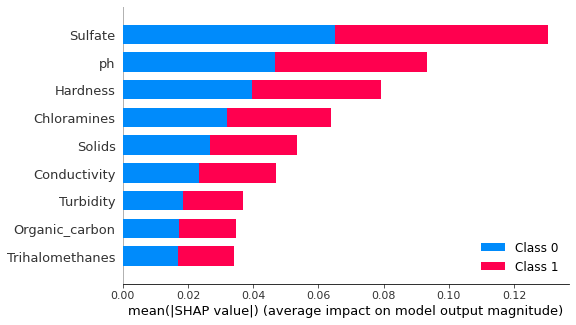

In [129]:
shap.summary_plot(shap_values, X, plot_type="bar")  # mean importance
# Sulfate, ph, hardness the most important for both classes according to SHAP Values

Sulfate has 781 (23.8%) missing values and is the most important feature according to Shap Values, therefore data imputting technique is very important and has influence on accuracy and precision. 